# Pré-processamento de Dados

## Objetivo
Preparar o dataset para modelagem, incluindo limpeza, feature engineering, seleção de features e escalonamento.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv('data/raw/UCI_Credit_Card.csv')

## Carregando e limpando os dados
Removendo coluna `ID`, renomeando variável alvo, e ajustando categorias inconsistentes em `EDUCATION` e `MARRIAGE`.

In [8]:
df = df.drop(columns=['ID'])

In [9]:
df = df.rename(columns={'default.payment.next.month': 'DEFAULT'})

In [10]:
df['EDUCATION'] = df['EDUCATION'].replace({0:4, 5:4, 6:4})
df['MARRIAGE'] = df['MARRIAGE'].replace({0:3})

## Tratamento de valores negativos
Removendo linhas com valores negativos nas faturas.

In [11]:
bill_cols = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']
pay_cols = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
pay_delay_cols = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']

In [12]:
mask_neg = (df[bill_cols] < 0).any(axis=1)
if mask_neg.sum() > 0:
    df = df.loc[~mask_neg].reset_index(drop=True)

## Separando features e alvo
Criando `x` com as variáveis preditoras e `y` com a variável alvo `DEFAULT`.

In [13]:
x = df.drop(columns='DEFAULT').copy()
y = df['DEFAULT'].copy()

## Feature Engineering
Criando novas features agregadas de faturas e pagamentos, além de métricas como `BILL_TO_LIMIT_RATIO` e `AVG_PAY_DELAY`.

In [14]:
x['SUM_ALL_BILL'] = x[bill_cols].sum(axis=1)
x['AVG_BILL'] = x[bill_cols].mean(axis=1)
x['MAX_BILL'] = x[bill_cols].max(axis=1)
x['STD_BILL'] = x[bill_cols].std(axis=1)
x['SUM_ALL_PAY'] = x[pay_cols].sum(axis=1)
x['AVG_PAY'] = x[pay_cols].mean(axis=1)
x['MAX_PAY'] = x[pay_cols].max(axis=1)
x['STD_PAY'] = x[pay_cols].std(axis=1)
x['BILL_TO_LIMIT_RATIO'] = x['SUM_ALL_BILL'] / x['LIMIT_BAL'].replace(0, np.nan)
x['PAY_TO_BILL_RATIO'] = x['SUM_ALL_PAY'] / x['SUM_ALL_BILL'].replace(0, np.nan)
x['AVG_PAY_DELAY'] = x[pay_delay_cols].mean(axis=1)
x['COUNT_DELAYS'] = (x[pay_delay_cols] > 0).sum(axis=1)
x['BILL_TO_LIMIT_RATIO'] = x['BILL_TO_LIMIT_RATIO'].fillna(0)
x['PAY_TO_BILL_RATIO'] = x['PAY_TO_BILL_RATIO'].fillna(0)

## One-Hot Encoding
Convertendo variáveis categóricas (`EDUCATION`, `MARRIAGE`) em dummies para modelagem.

In [15]:
categories_cols = ['EDUCATION', 'MARRIAGE']
x = pd.get_dummies(x, columns=categories_cols, drop_first=True)

## Tratamento de outliers
Aplicando método IQR para limitar valores extremos nas features numéricas.

In [16]:
def iqr_clip(df_in, cols):
    df = df_in.copy()
    for col in cols:
        if col not in df.columns:
            continue
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower, upper)
    return df

In [17]:
numeric_cols_for_clip = [
    'LIMIT_BAL', 'AGE',
    'sum_all_bill', 'avg_bill', 'max_bill', 'min_bill', 'std_bill',
    'sum_all_pay', 'avg_pay', 'max_pay', 'std_pay',
    'bill_to_limit_ratio', 'pay_to_bill_ratio', 'avg_pay_delay', 'count_delays'
]

In [18]:
x = iqr_clip(x, numeric_cols_for_clip)

## Correlação e Multicolinearidade
Removendo features altamente correlacionadas (correlation > 0.9) e usando VIF para reduzir multicolinearidade.

In [19]:
corr_matrix = x.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = upper.columns[upper.gt(0.9).any()]
x = x.drop(columns=to_drop)

In [20]:
x_num = x.select_dtypes(include=[np.number]).fillna(0)
vif = pd.Series(
    [variance_inflation_factor(x_num.values, i) for i in range(x_num.shape[1])],
    index=x_num.columns
)
x.drop(columns=vif[vif > 10].index)

/usr/local/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,LIMIT_BAL,SEX,AGE,BILL_AMT1,STD_BILL,BILL_TO_LIMIT_RATIO,PAY_TO_BILL_RATIO,COUNT_DELAYS,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
0,20000.0,2,24.0,3913.0,1761.633219,0.385200,0.089434,2,True,False,False,False,False
1,120000.0,2,26.0,2682.0,637.967841,0.142308,0.292791,2,True,False,False,True,False
2,90000.0,2,34.0,29239.0,6064.518593,1.129478,0.108388,0,True,False,False,True,False
3,50000.0,2,37.0,46990.0,10565.793518,4.626680,0.036259,0,True,False,False,False,False
4,50000.0,1,57.0,8617.0,10668.590074,2.186780,0.540054,0,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28065,80000.0,1,34.0,72557.0,3510.612335,5.886662,0.045654,6,True,False,False,True,False
28066,220000.0,1,39.0,188948.0,86697.439530,3.297041,0.058661,0,False,True,False,False,False
28067,150000.0,1,43.0,1683.0,3200.534247,0.141213,0.684071,0,False,True,False,True,False
28068,30000.0,1,37.0,3565.0,9354.149660,2.349867,0.443997,3,True,False,False,True,False


## Seleção de Features
Selecionando as top features mais relevantes usando `SelectKBest` com teste ANOVA F.

In [21]:
selector = SelectKBest(score_func=f_classif, k=12)
selector.fit(x, y)
top_features = x.columns[selector.get_support()]

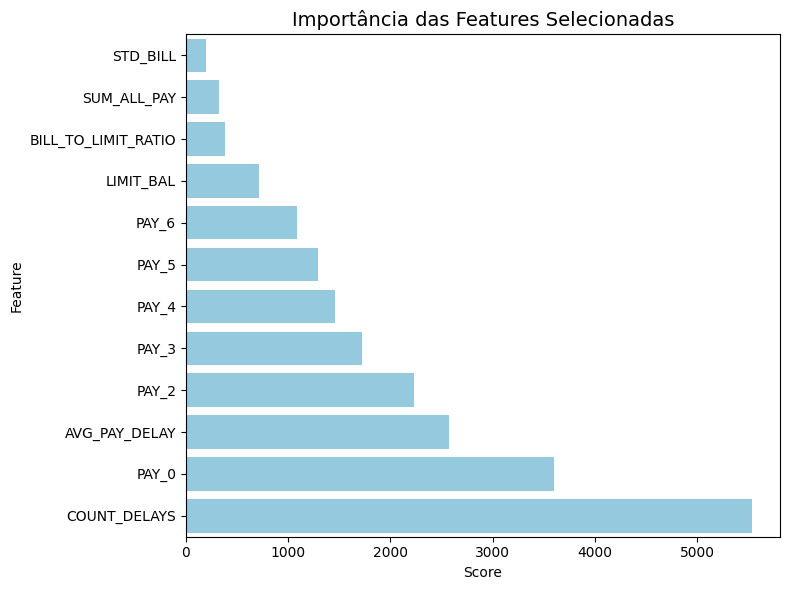

In [ ]:
scores = selector.scores_[selector.get_support()]

feat_importance = pd.DataFrame({
    'Feature': top_features,
    'Score': scores
}).sort_values(by='Score', ascending=True)

plt.figure(figsize=(8,6))
sns.barplot(x='Score', y='Feature', data=feat_importance, color='skyblue')
plt.title("Importância das Features Selecionadas", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Escalonamento
Dividindo dados em treino e teste, e aplicando `StandardScaler` nas features selecionadas.

In [23]:
x_train, x_test, y_train, y_test = train_test_split(
    x[top_features], y, stratify=y, test_size=0.2, random_state=42
)

In [24]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Salvar dados processados
Exportando `x_train`, `x_test`, `y_train` e `y_test` para uso nos próximos notebooks.

In [25]:
pd.DataFrame(x_train_scaled, columns=top_features).to_csv("data/processed/x_train.csv", index=False)
pd.DataFrame(x_test_scaled, columns=top_features).to_csv("data/processed/x_test.csv", index=False)

In [26]:
y_train.to_csv("data/processed/y_train.csv", index=False)
y_test.to_csv("data/processed/y_test.csv", index=False)